# Base Rate Neglect Distribution and Density Clustering Analysis

In [1]:
#!pip install yellowbrick 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

## Import data

In [3]:
df = pd.read_csv("/Users/joey/Desktop/Woodman Scholar RA/treatment_data.csv") ##Replace filepath!
df

,dataset,unique_id,round,pc,pd
0,1,1001,1,20,80
1,1,1001,2,20,80
2,1,1001,3,20,80
3,1,1001,4,20,80
4,1,1001,5,20,80
...,...,...,...,...,...
16055,8,8100,16,5,95
16056,8,8100,17,5,95
16057,8,8100,18,5,95
16058,8,8100,19,5,95


## Calculate averages across trials

In [4]:
cols = ['dataset', 'unique_id', 'pc', 'pd']
average_df = df[cols].groupby('unique_id').mean()

## Run elbow method to determine optimal amount of clusters on combined dataset

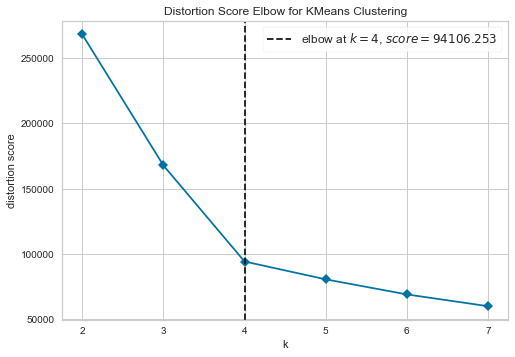

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
## taken from https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, locate_elbow = True, k=(2,8), timings=False)

visualizer.fit(average_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Run Elbow Method on Treatments 1 - 4

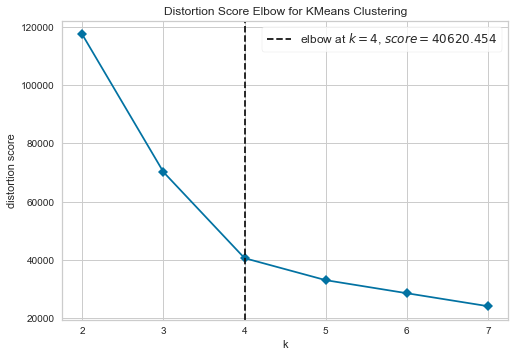

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
trials_one_to_four = average_df[average_df["dataset"] <= 4.0] 

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, locate_elbow = True, k=(2,8), timings=False)

visualizer.fit(trials_one_to_four)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Run Elbow Method on Treatments 5 - 8

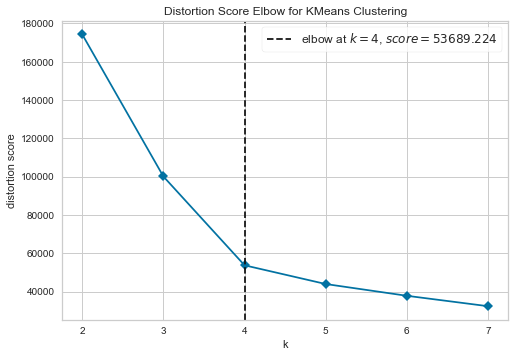

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
trials_five_to_eight = average_df[average_df["dataset"] >= 4.0] 

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, locate_elbow = True, k=(2,8), timings=False)

visualizer.fit(trials_five_to_eight)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Here we use the elbow method to determine the optimal number of clusters to partition our data into. The elbow method works by comparing the amount of 'distortion' between different numbers of clusters. Distortion is defined as the sum of square errors from each data point in the cluster to the centriod. For each cluster a centriod is calculated by taking the average x and y coordinates of all points within the cluster. Distortion then measures the distance between each point in the cluster and that centroid. We see large reductions in distortion from 1 - 4 clusters. After 4 clusters, the reductions in distortion quickly diminish.

## Verify correct number of clusters with Silhouette Score

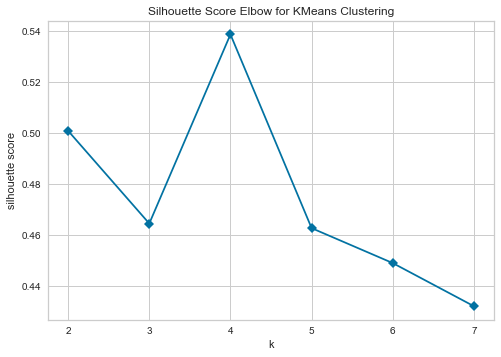

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [8]:
## taken from https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

# This is another elbow method visualization that is an alternative that's worth looking at. It recommends 2 clusters instead of 4, however.
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, metric='silhouette', locate_elbow = False, k=(2,8), timings=False)

visualizer.fit(average_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

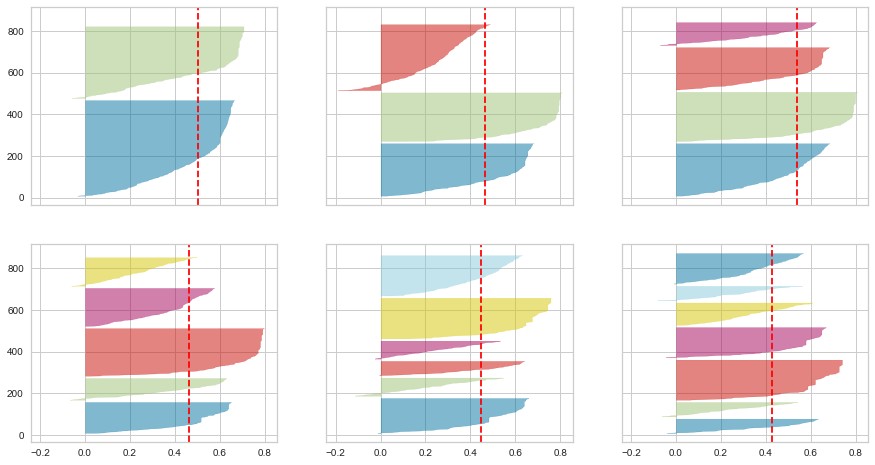

In [9]:
## taken from https://towardsdatascience.com/elbow-method-is-not-sufficient-to-find-best-k-in-k-means-clustering-fc820da0631d

from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
  
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i+1, 3)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(average_df)

The silhouette score is another method for determining the optimal number of clusters to partition a dataset into. Unlike the elbow method, the silhouette score considers how well clusters are seperated from other clusters. A higher score is better. The silhouette score is defined by averaging the silhouette coefficients of each data point. The silhouette coefficient is calculated by comparing the average distance of a data point from other data points in its cluster to the average distance of a data point from points in the nearest cluster. From the first graph we can see that the silhouette score peaks at 4. The second set of graphs illustrate that at 4 clusters the data is relatively evenly split between clusters, another desirable trait.

## Use Gaussian Mixture Models to Group Treatments 1 - 4 into Clusters

Gaussian Mixture Models seem to be the most common distribution clustering in Python.
https://scikit-learn.org/stable/modules/mixture.html#mixture What is neat about this clustering method is that you can output the probabilities of a datapoint being in one cluster or another. Unfortunately, it's finicky and doesn't group in intuitive clusters after specifying 2 or 3 clusters. 

[Text(0.5, 1.0, 'Treatments 1 - 4 - c and d variables with GMM clustering')]

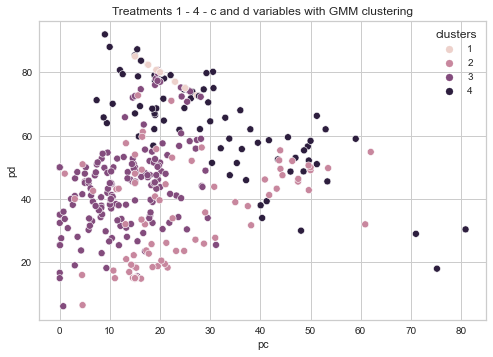

In [10]:
gmm = mixture.GaussianMixture(n_components=4).fit(trials_one_to_four)
labels = gmm.predict(trials_one_to_four)

trials_one_to_four['clusters'] = labels+1

sns.scatterplot(data = trials_one_to_four, x = 'pc', y = 'pd', hue='clusters').set(title='Treatments 1 - 4 - c and d variables with GMM clustering')

In [11]:
probs = gmm.predict_proba(trials_one_to_four[["pd","pc","clusters"]])
print(probs[:10].round(3))

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


## GMM on Treatments 5 - 8

[Text(0.5, 1.0, 'Treatments 5 - 8 - c and d variables with GMM clustering')]

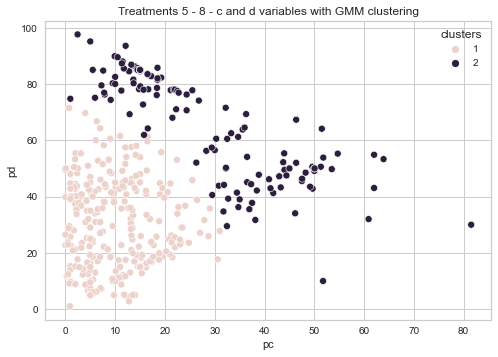

In [12]:
gmm = mixture.GaussianMixture(n_components=2).fit(trials_five_to_eight)
labels = gmm.predict(trials_five_to_eight)

trials_five_to_eight['clusters'] = labels+1

sns.scatterplot(data = trials_five_to_eight, x = 'pc', y = 'pd', hue='clusters').set(title='Treatments 5 - 8 - c and d variables with GMM clustering')

In [13]:
probs = gmm.predict_proba(trials_five_to_eight[["pd","pc","clusters"]])
print(probs[:10].round(3))

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


## DBSCAN Clustering on Treatments 1 - 4

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) seems like the most widely used density based clustering method. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html Like DBSCAN, this clustering groups data points in understandable clusters when low numbers of clusters are specified, but for larger number of clusters it doesn't seem helpful.

[Text(0.5, 1.0, 'Treatments 1 - 4 - c and d variables with DBSCAN clustering')]

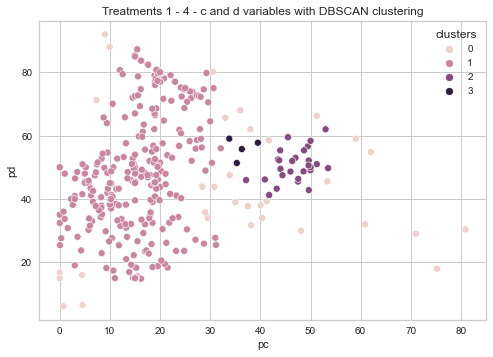

In [14]:
dbscan = DBSCAN(eps=5).fit(trials_one_to_four)
labels = dbscan.fit_predict(trials_one_to_four)

trials_one_to_four['clusters'] = labels+1

sns.scatterplot(data = trials_one_to_four, x = 'pc', y = 'pd', hue='clusters').set(title='Treatments 1 - 4 - c and d variables with DBSCAN clustering')

## DBSCAN on 5 - 8

[Text(0.5, 1.0, 'Treatments 5 - 8 - c and d variables with DBSCAN clustering')]

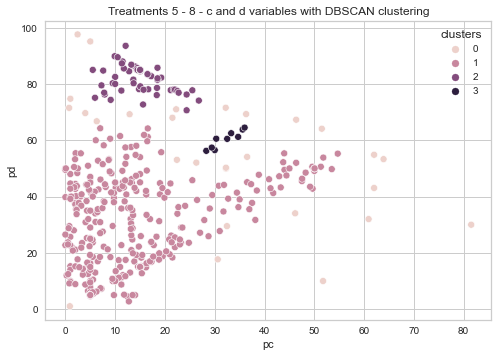

In [15]:
dbscan = DBSCAN(eps=5).fit(trials_five_to_eight)
labels = dbscan.fit_predict(trials_five_to_eight)

trials_five_to_eight['clusters'] = labels+1

sns.scatterplot(data = trials_five_to_eight, x = 'pc', y = 'pd', hue='clusters').set(title='Treatments 5 - 8 - c and d variables with DBSCAN clustering')